In [1]:
library(Gviz)
library(dplyr)
library(GenomeInfoDb)
library(Rsamtools)
library(GenomicFeatures)
library(GenomicRanges)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

In [2]:
PlotCoverage_org<-function(genome_gr, 
                       geneSymbol="", 
                       wig_data=NULL, 
                       bamfiles=NULL,
                       peaks.annot = NULL,
                       label.transcripts = FALSE,
                       wig_same_strand=TRUE, 
                       genome=NULL, 
                       pdf_output = FALSE, 
                       wig_data.tracknames=NULL, 
                       bamfile.tracknames=NULL,
                       output_file_name='', 
                       zoom_3UTR=FALSE,
                       annotation.fontsize=NULL,
                       axis.fontsize=NULL,
                       ylims = NULL
                       )
{
  # Check that gene_name field exists
  GenomeInfoDb::seqlevelsStyle(genome_gr) <- "UCSC"
  idx <-which(genome_gr$gene_name == geneSymbol)
  if (length(idx) == 0) { 
    warning("Could not find gene name. Please check spelling (and case)")
    return(NULL)
  }
  # Work out the genomic range to extract from
  genome_gr <- genome_gr[idx]
  start <- min(IRanges::start(IRanges::ranges(genome_gr)))
  end <- max(IRanges::end(IRanges::ranges(genome_gr)))
  # should I check that all returned chromosomes and strands are the same? They should be the same
  # Currently just grabbing first entry
  chrom <- as.character(GenomicRanges::seqnames(genome_gr))[1]
  gene_strand <- as.character(BiocGenerics::strand(genome_gr))[1]
  toExtract_gr <- GenomicRanges::GRanges(seqnames=chrom, ranges=IRanges::IRanges(start-1 , width=end-start+3), strand=gene_strand)

  # Assemble gene annotation track
  gene_gr <- IRanges::subsetByOverlaps(genome_gr, toExtract_gr)
  GenomeInfoDb::seqlevelsStyle(gene_gr) <- "UCSC"
  GenomeInfoDb::seqlevels(gene_gr) <- chrom

  # Following lines is a hack to get gene symbol to be name of transcripts.
  gene_name_idx <- which(names(GenomicRanges::elementMetadata(gene_gr)) == "gene_name")
  gene_id_idx <- which(names(GenomicRanges::elementMetadata(gene_gr)) == "gene_id")
  names(GenomicRanges::elementMetadata(gene_gr))[gene_id_idx] <- "ensemble_id"
  names(GenomicRanges::elementMetadata(gene_gr))[gene_name_idx] <- "gene_id"

  gene_txdb <- GenomicFeatures::makeTxDbFromGRanges(gene_gr)

  if (label.transcripts) {
    transcript.fontsize = annotation.fontsize
  } else {transcript.fontsize = 0}
  gtrack <- Gviz::GeneRegionTrack(gene_txdb, 
                                  start = start, 
                                  end = end, 
                                  chromosome=chrom, 
                                  name= geneSymbol,
                                  just.group = "above",
                                  transcriptAnnotation = "symbol",
                                  showId = FALSE,
                                  fontsize.group = transcript.fontsize)

  ### Add peaks annotations if provided
  if (!is.null(peaks.annot)) {
    start.sites <- as.numeric(sub(".*:.*:(.*)-.*:.*", "\\1", peaks.annot))
    end.sites <- as.numeric(sub(".*:.*:.*-(.*):.*", "\\1", peaks.annot))
    peak.widths <- end.sites - start.sites
    peak.names <- names(peaks.annot)
    if (is.null(peak.names)) peak.names <- peaks.annot
    
    atrack <- Gviz::AnnotationTrack(start=start.sites, 
                                    width=peak.widths, 
                                    chromosome=chrom, 
                                    strand="*",
                                    name="Peak",
                                    group=peak.names, 
                                    genome=genome, 
                                    just.group="above",
                                    showId = TRUE,
                                    fontsize.group = annotation.fontsize,
                                    rotation.title=90)
    gtrack <- c(gtrack, atrack)
  }
  
  ##### Assemble data track(s)
  dtrack <- list()  # Add data tracks assembled on this list

  ## Assemble wig data tracks
  wig_tracks <- list()
  if (! is.null(wig_data)) {
    if (typeof(wig_data) != "S4")  # assume a dataframe or list which we can create several df.
    { nc <- ncol(wig_data)  # 4 columns are chrom, start, end, strand. Thereafter are sample data
    wig_data <-  GenomicRanges::makeGRangesFromDataFrame(wig_data,keep.extra.columns=TRUE)
    }
    GenomeInfoDb::seqlevelsStyle(wig_data) <- "UCSC"
    
    if (! wig_same_strand) {  
      toExtract_gr <- GenomicRanges::invertStrand(toExtract_gr)  }
    dtrack_gr <- IRanges::subsetByOverlaps(wig_data, toExtract_gr)
    
    
    GenomeInfoDb::seqlevels(dtrack_gr) <- chrom
    sample_col_idx <- 1: ncol(S4Vectors::mcols(wig_data))
    
    # Now assemble coverage plots
    for(i in sample_col_idx)  {
      tmp_gr <- dtrack_gr
      S4Vectors::mcols(tmp_gr) <- S4Vectors::mcols(tmp_gr)[i]
      dtrack_name <- names(S4Vectors::mcols(tmp_gr))
      wig_tracks[[length(wig_tracks)+1]] <- Gviz::DataTrack(tmp_gr, name=dtrack_name, type = "histogram", genome=genome)
    }
    
  }


  ## Load BAM files onto dtrack
  if (length(bamfiles) > 0) { 
    # Set track naming
    if (length(bamfile.tracknames) > 0) {  # Defined track names has been passed to function.
      if (length(bamfile.tracknames) == length(bamfiles)) { 
        names(bamfile.tracknames) <- bamfiles 
      } else { warning("BAM track names does not match number of bam files passed. 
              Replacing with filenames.") 
        bamfile.tracknames <- bamfiles
        names(bamfile.tracknames) <- bamfiles
      }
    } else { # Default is to use bamfile names.
      bamfile.tracknames <- bamfiles
      names(bamfile.tracknames) <- bamfiles
    }
    
    # Extend gene window 50nt in both directions    
    toExtract_gr <- GenomicRanges::GRanges(seqnames=chrom, ranges=IRanges::IRanges(start-50 , width=end-start+50), strand=gene_strand)
    
    
    for(i in bamfiles) {
      bamHeader <- Rsamtools::scanBamHeader(i)
      if (length(grep(pattern = chrom,x = names(bamHeader[[i]]$targets))) == 0) {   
        GenomeInfoDb::seqlevelsStyle(toExtract_gr) <- "NCBI" 
      } else {   
        GenomeInfoDb::seqlevelsStyle(toExtract_gr) <- "UCSC" }
      
      param <- Rsamtools::ScanBamParam(which = toExtract_gr)
      bf <-Rsamtools::BamFile(i)
      
      open(bf)
      chunk0 <- GenomicAlignments::readGAlignments(bf,param=param)
      GenomeInfoDb::seqlevelsStyle(chunk0) <- "UCSC"
      close(bf)
      idx <- which(as.character(BiocGenerics::strand(chunk0)) == gene_strand)
      if (length(idx) == 0) {        
        next; }
      tmp <-GenomicRanges::coverage(chunk0[idx])
      
      gr <- GenomicRanges::GRanges(seqnames=chrom, ranges=IRanges::IRanges(start:end, width=1), strand=gene_strand)
      S4Vectors::mcols(gr) <- as.numeric(tmp[[chrom]])[start:end]
      dtrack[[length(dtrack)+1]] <- Gviz::DataTrack(gr, name=bamfile.tracknames[i], type = "histogram", genome=genome)
      
    }
  }


  if (length(wig_tracks) > 0)
  {
    dtrack <- c(wig_tracks, dtrack)
  }

  toPlot <- c(gtrack, dtrack)

  if (pdf_output)
  {
    if (output_file_name == '')
    { warning("No file name provided")
      pdf_output = FALSE
    }
    else
    {  pdf(file=output_file_name,width = 24,height = 18)
    }
  }
  extra.space = round( (end - start) * 0.02 )
  Gviz::plotTracks(toPlot, 
                   from = start,
                   to = end,
                   extend.left = extra.space,
                   extend.right = extra.space,
                   chromosome= chrom, 
                   transcriptAnnotation = "transcript",
                   showId = TRUE,
                   fontsize = axis.fontsize,
                   ylim = ylims)

  if (zoom_3UTR)
  {
    idx <- which(genome_gr$type == 'three_prime_utr')
    # Work out the genomic range of UTR
    start <- min(IRanges::start(IRanges::ranges(genome_gr[idx])))
    end <- max(IRanges::end(IRanges::ranges(genome_gr[idx])))
    extra.space = round( (end - start) * 0.02 )
    Gviz::plotTracks(toPlot, 
                     from = start, 
                     to = end, 
                     extend.left = extra.space,
                     extend.right = extra.space,
                     chromosome= chrom, 
                     transcriptAnnotation = "transcript",
                     showId = FALSE,
                     fontsize = axis.fontsize,
                     ylim = ylims)
  }



  if (pdf_output)
  {  dev.off() }

}

In [3]:
reference.file <- paste0("/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes/genes.gtf")
gtf_gr <- rtracklayer::import(reference.file)

In [42]:
inh_bams = c('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Inhibitory/Inhibitory_CTRLs.bam',
'/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Inhibitory/Inhibitory_C9ALS.bam',
 '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Inhibitory/Inhibitory_sALS.bam')
 names(inh_bams) = c('CTRL', 'C9ALS', 'sALS')

In [43]:
exc_bams = c('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Excitatory/Excitatory_CTRLs.bam',
'/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Excitatory/Excitatory_C9ALS.bam',
 '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Excitatory/Excitatory_sALS.bam')
 names(exc_bams) = c('CTRL', 'C9ALS', 'sALS')

Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."


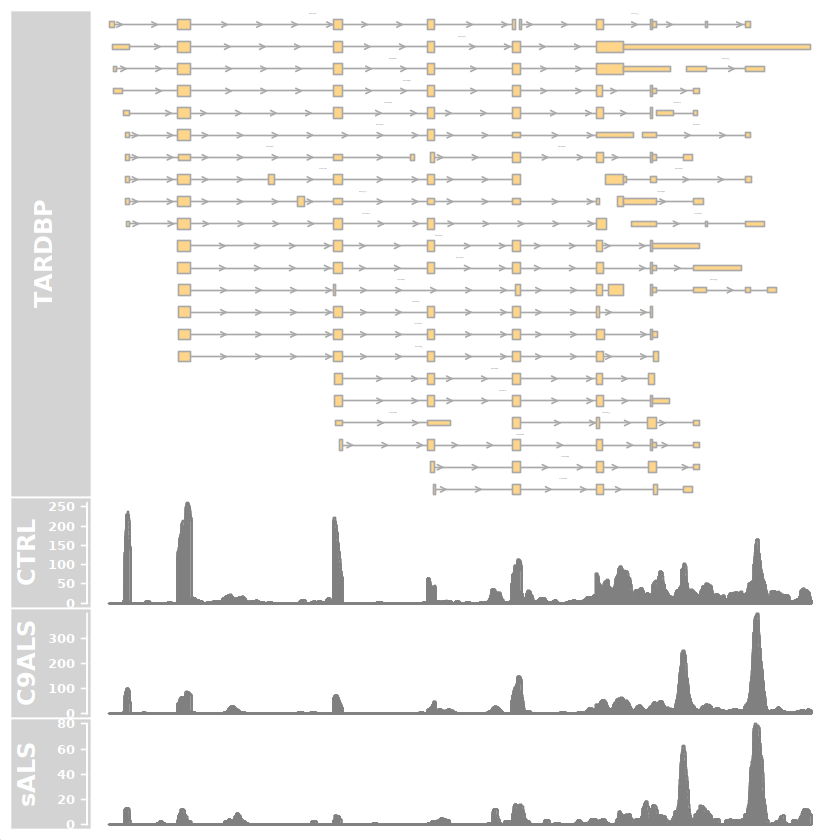

In [5]:
PlotCoverage_org(genome_gr = gtf_gr, geneSymbol = "TARDBP", genome = "hg38",
    bamfiles = inh_bams , bamfile.tracknames=names(inh_bams))

Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."


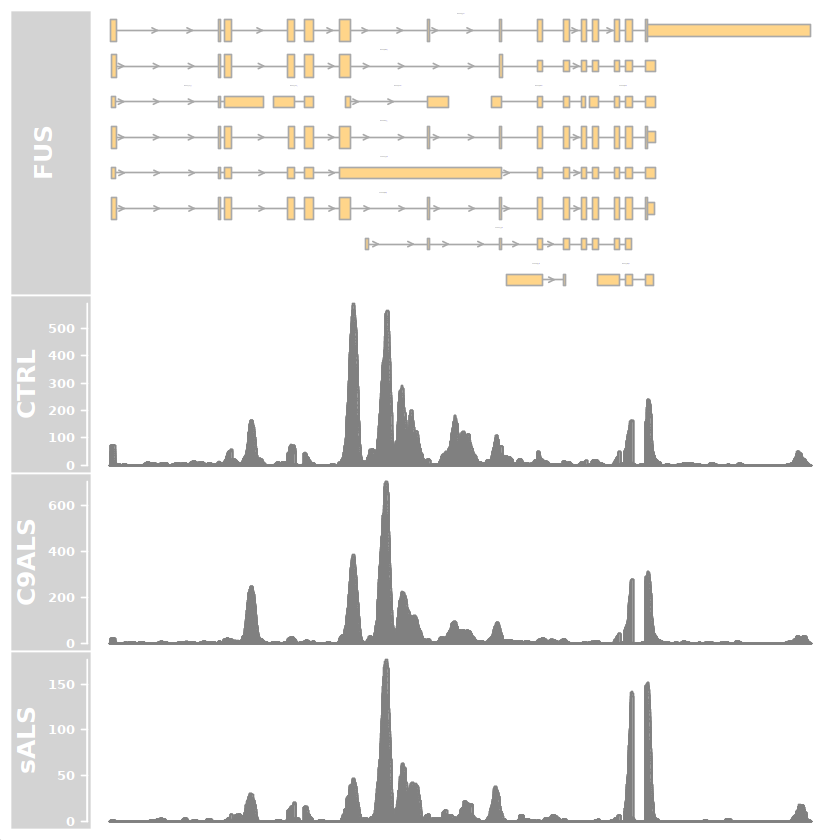

In [45]:
PlotCoverage_org(genome_gr = gtf_gr, geneSymbol = "FUS", genome = "hg38",
    bamfiles = inh_bams , bamfile.tracknames=names(inh_bams))

In [32]:
colnames(gtf_gr_df)

[1] "seqnames"                 "start"                   
 [3] "end"                      "width"                   
 [5] "strand"                   "source"                  
 [7] "type"                     "score"                   
 [9] "phase"                    "gene_id"                 
[11] "gene_version"             "gene_type"               
[13] "gene_name"                "level"                   
[15] "hgnc_id"                  "tag"                     
[17] "havana_gene"              "transcript_id"           
[19] "transcript_version"       "transcript_type"         
[21] "transcript_name"          "transcript_support_level"
[23] "havana_transcript"        "exon_number"             
[25] "exon_id"                  "exon_version"            
[27] "protein_id"               "ccdsid"                  
[29] "ont"

In [36]:
# for each transcript_name get their width and keep the biggest width as the length of that transcript. get the tran
gtf_gr_df = gtf_gr_df %>% filter(gene_name=='TARDBP') %>% filter(transcript_name=='TARDBP-201')

In [37]:
gtf_gr_2 = makeGRangesFromDataFrame(gtf_gr_df, keep.extra.columns = TRUE)

Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."


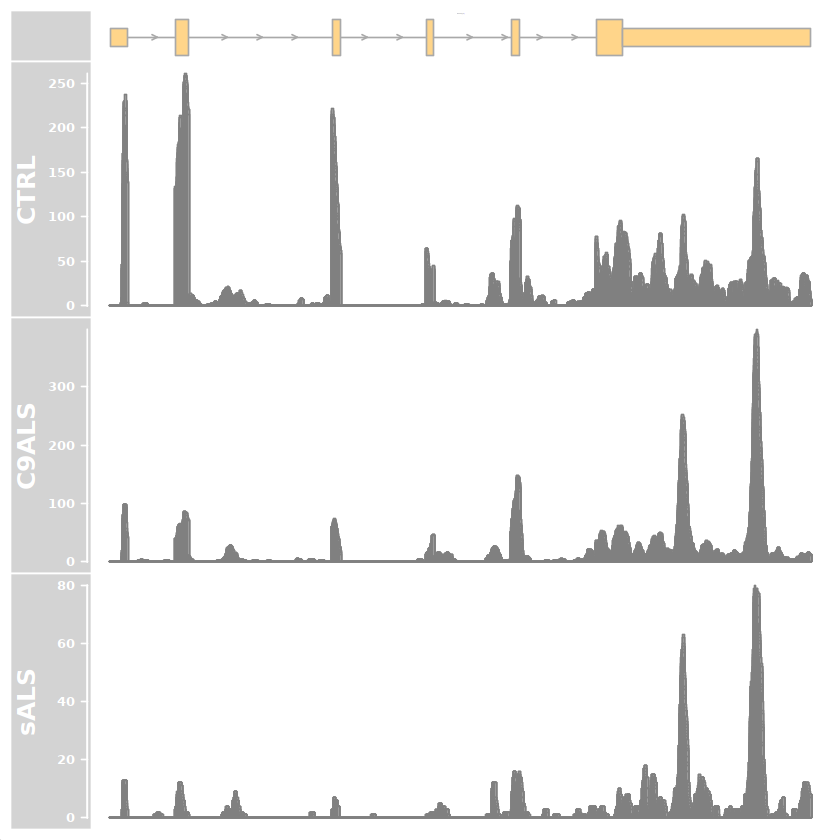

In [38]:
PlotCoverage_org(genome_gr = gtf_gr_2, geneSymbol = "TARDBP", genome = "hg38",
    bamfiles = inh_bams , bamfile.tracknames=names(inh_bams))

Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."


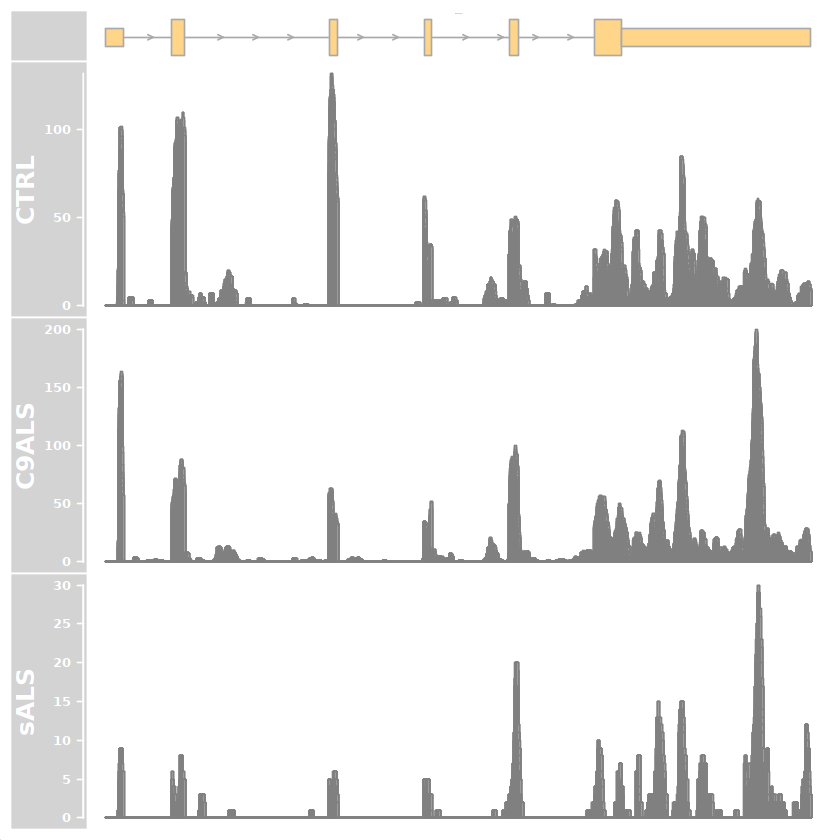

In [44]:
PlotCoverage_org(genome_gr = gtf_gr_2, geneSymbol = "TARDBP", genome = "hg38",
    bamfiles = exc_bams , bamfile.tracknames=names(exc_bams))